# Import Package

In [ ]:
!pip install --upgrade kagglehub
import kagglehub

In [ ]:
multi_cancer_path = kagglehub.dataset_download('obulisainaren/multi-cancer') # Use the instance for downloading the dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import *
import torch.optim as optim
from collections import Counter
import json
from sklearn.metrics import f1_score
from google.colab import files
from torch.optim.lr_scheduler import CosineAnnealingLR

# Load Dataset

In [ ]:
def get_data(path):
    classes = []
    images = []
    labels = []
    for p in path:
      for root, dirs, files in os.walk(p):
          for file in files:
              if file.endswith(('.jpg', '.png', '.jpeg')):  # 只處理圖片檔案
                  # 取得完整檔案路徑
                  file_path = os.path.join(root, file)
                  # 取得相對於根目錄的路徑
                  rel_path = os.path.relpath(root, p)
                  # 取得最後一層資料夾名稱作為標籤
                  label = os.path.basename(root)

                  if label not in classes:
                      classes.append(label)

                  images.append(file_path)
                  labels.append(classes.index(label))

    n_classes = len(set(labels))
    labels = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=n_classes)

    print(f"找到 {n_classes} 個類別：")
    for i, class_name in enumerate(classes):
        print(f"類別 {i}: {class_name}")

    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels,
        test_size=0.2,
        random_state=24,
        stratify=labels  # 確保每個類別的比例一致
    )

    train_labels = torch.tensor(train_labels, dtype=torch.float)
    test_labels = torch.tensor(test_labels, dtype=torch.float)

    return train_images, test_images, train_labels, test_labels, n_classes, classes

In [ ]:
path = []

# subset_name 放你要處理的子類別名稱，例如 Brain Cancer 或 Cervical Cancer 等等
subset_name = "Kidney Cancer"
path.append(multi_cancer_path + "/Multi Cancer/Multi Cancer/" + subset_name + "/")

train_images, test_images, train_labels, test_labels, n_classes, classes = get_data(path)


找到 2 個類別：
類別 0: kidney_tumor
類別 1: kidney_normal


<ipython-input-4-0b0a65a57b0e>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float)
<ipython-input-4-0b0a65a57b0e>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels, dtype=torch.float)


# Create DataLoader

In [ ]:
class MultiCancerDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images

        self.mean, self.std = self._calculate_mean_std()
        self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean,std=self.std)
            ])

        self.labels = labels
        print("Dataset build")

    def _calculate_mean_std(self):
        means = []
        stds = []

        # 收集所有圖片的均值和標準差
        for img in self.images:
            tmp_img = Image.open(img).convert('RGB')
            tmp_img = transforms.ToTensor()(tmp_img)  # 轉換為 tensor

            # 現在 img 的 shape 是 [3, H, W]
            means.append(torch.mean(tmp_img, dim=[1,2]))  # 計算每個 channel 的均值
            stds.append(torch.std(tmp_img, dim=[1,2]))    # 計算每個 channel 的標準差

        # 得到三個 channel 的統計值
        mean = torch.mean(torch.stack(means), dim=0)  # [mean_R, mean_G, mean_B]
        std = torch.mean(torch.stack(stds), dim=0)    # [std_R, std_G, std_B]

        return mean, std

    def __getitem__(self, idx):
        # 讀取圖片
        image = self.images[idx]
        image = Image.open(image).convert('RGB')
        image = self.transform(image)

        # 取得標籤
        label = self.labels[idx]

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
train_dataset = MultiCancerDataset(train_images[:5000], train_labels[:5000])
valid_dataset = MultiCancerDataset(train_images[5000:min(7000, len(train_images))], train_labels[5000:min(7000, len(train_images))])
test_dataset = MultiCancerDataset(test_images[:2000], test_labels[:2000])

Dataset build
Dataset build
Dataset build


In [ ]:
batch_size = 32
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Varify num of each class in dataset

In [ ]:
labels = []
for _, label in train_data:
    for l in label:  # 批次中的每個標籤
        label_name = classes[l.argmax().item()]
        labels.append(label_name)
label_counts = Counter(labels)

print("在 train_data 中的類別統計：")
print(f"總類別數: {len(label_counts)}")
print("\n各類別統計:")
for label, count in label_counts.items():
   print(f"類別 {label}: {count} 筆")

在 train_data 中的類別統計：
總類別數: 2

各類別統計:
類別 kidney_tumor: 2491 筆
類別 kidney_normal: 2509 筆


In [ ]:
labels = []
for _, label in valid_data:
    for l in label:  # 批次中的每個標籤
        label_name = classes[l.argmax().item()]
        labels.append(label_name)
label_counts = Counter(labels)

print("在 valid_data 中的類別統計：")
print(f"總類別數: {len(label_counts)}")
print("\n各類別統計:")
for label, count in label_counts.items():
   print(f"類別 {label}: {count} 筆")

在 valid_data 中的類別統計：
總類別數: 2

各類別統計:
類別 kidney_tumor: 1040 筆
類別 kidney_normal: 960 筆


In [ ]:
labels = []
for _, label in test_data:
    for l in label:  # 批次中的每個標籤
        label_name = classes[l.argmax().item()]
        labels.append(label_name)
label_counts = Counter(labels)

print("在 test_data 中的類別統計：")
print(f"總類別數: {len(label_counts)}")
print("\n各類別統計:")
for label, count in label_counts.items():
   print(f"類別 {label}: {count} 筆")

在 test_data 中的類別統計：
總類別數: 2

各類別統計:
類別 kidney_tumor: 1000 筆
類別 kidney_normal: 1000 筆


# Build Model

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
def create_model(n_classes):
    # model = nn.Sequential(
    #     # Head
    #     nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
    #     nn.BatchNorm2d(64),
    #     nn.LeakyReLU(negative_slope=0.01, inplace=True),

    #     # Backbone-0 (64 -> 64)
    #     BasicBlock(64, 64),
    #     BasicBlock(64, 64),

    #     # Backbone-1 (64 -> 128)
    #     BasicBlock(64, 128, stride=2),
    #     BasicBlock(128, 128),

    #     # Backbone-2 (128 -> 256)
    #     BasicBlock(128, 256, stride=2),
    #     BasicBlock(256, 256),

    #     # Backbone-3 (256 -> 512)
    #     BasicBlock(256, 512, stride=2),
    #     BasicBlock(512, 512),
    #     nn.AdaptiveAvgPool2d((1, 1)),

    #     # Predictor
    #     nn.Flatten(),
    #     nn.Linear(512, n_classes)
    # )

    # model = nn.Sequential(
    #     # Head
    #     nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # 降低初始通道數從64到32
    #     nn.BatchNorm2d(32),
    #     nn.LeakyReLU(negative_slope=0.01, inplace=True),

    #     # Backbone-0 (32 -> 64)
    #     BasicBlock(32, 64, stride=2),  # 直接在第一個Block進行降採樣

    #     # Backbone-1 (64 -> 128)
    #     BasicBlock(64, 128, stride=2),

    #     # Backbone-2 (128 -> 256)
    #     BasicBlock(128, 256, stride=2),
    #     BasicBlock(256, 256),  # 保留一個額外的Block在最後階段

    #     nn.AdaptiveAvgPool2d((1, 1)),

    #     # Predictor
    #     nn.Flatten(),
    #     nn.Linear(256, n_classes)  # 降低最終特徵維度從512到256
    # )

    model = nn.Sequential(
        # Head
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Dropout2d(p=0.1),  # 添加較小的 dropout，避免初始特徵丟失過多

        # Backbone-0 (32 -> 64)
        BasicBlock(32, 64, stride=2),
        nn.Dropout2d(p=0.2),  # 隨著網絡深入，逐漸增加 dropout 率

        # Backbone-1 (64 -> 128)
        BasicBlock(64, 128, stride=2),
        nn.Dropout2d(p=0.25),  # 中間層使用適中的 dropout 率

        # Backbone-2 (128 -> 256)
        BasicBlock(128, 256, stride=2),
        nn.Dropout2d(p=0.3),  # 深層特徵使用較大的 dropout 率
        BasicBlock(256, 256),
        nn.Dropout2d(p=0.3),  # 最後的特徵層保持相同的 dropout 率

        nn.AdaptiveAvgPool2d((1, 1)),

        # Predictor
        nn.Flatten(),
        nn.Dropout(p=0.5),  # 全連接層前使用較大的 dropout
        nn.Linear(256, n_classes)
    )
    return model

In [ ]:
print(n_classes)
resnet_model = create_model(n_classes)
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
lr_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=40,
        eta_min=1e-6
    )

2


# GPU Check

In [ ]:
# 如果沒有 GPU 的話，點選左上執行階段 -> 變更執行階段類型 -> 選擇 T4 GPU
if torch.cuda.is_available():
    print(f"有 GPU 可供使用！裝置名稱：{torch.cuda.get_device_name(0)}")
    print(f"可用的 GPU 數量：{torch.cuda.device_count()}")
else:
    print("沒有 GPU 可供使用。")

有 GPU 可供使用！裝置名稱：Tesla T4
可用的 GPU 數量：1


In [ ]:
resnet_model.to('cuda')

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01, inplace=True)
  (3): Dropout2d(p=0.1, inplace=False)
  (4): BasicBlock(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): Lea

# Train and Test

In [ ]:
def elastic_net_loss(original_loss, model, lambda1=1e-5, lambda2=1e-4):
    l1_reg = torch.tensor(0., device='cuda')  # 初始化 L1 正則化
    l2_reg = torch.tensor(0., device='cuda')  # 初始化 L2 正則化
    for param in model.parameters():
        l1_reg += torch.norm(param, 1)  # L1 正則化
        l2_reg += torch.norm(param, 2) ** 2  # L2 正則化
    return original_loss + lambda1 * l1_reg + lambda2 * l2_reg  # 總損失

In [ ]:
def train_step(model, optimizer, lr_scheduler, criterion, train_data, valid_data):

    model.train()
    train_losses = []
    for batch_idx, (images, labels) in enumerate(tqdm(train_data)):
        images, labels = images.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        output = model(images)
        # loss = criterion(output, labels)

        original_loss = criterion(output, labels)
        loss = elastic_net_loss(original_loss, model, lambda1=1e-5, lambda2=1e-4)

        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # 驗證階段
    model.eval()
    valid_losses = []
    correct = 0
    total = 0
    # 用於計算 F1 score
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in valid_data:
            images, labels = images.to('cuda'), labels.to('cuda')
            output = model(images)

            loss = criterion(output, labels)
            valid_losses.append(loss.item())

            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

            # 收集預測結果和真實標籤用於計算 F1 score
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

    # 使用驗證loss來更新學習率
    valid_loss = np.mean(valid_losses)
    lr_scheduler.step()

    # 計算 F1 score (使用 macro 平均)
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return (
        np.mean(train_losses),
        np.mean(valid_losses),
        lr_scheduler.get_last_lr()[0],
        100 * correct / total,
        f1
    )

In [ ]:
def test_step(model, test_data):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in test_data:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

    return 100 * correct / total

In [ ]:
K = 5
epoch = 8

train_losses = []
valid_losses = []
lrs = []
test_accs = []
valid_accs = []
f1s = []

from sklearn.model_selection import KFold
kfold = KFold(n_splits=K)



for fold_i, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'train size: {len(train_ids)}, val size: {len(val_ids)}')


    # Sample elements from selected ids
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
    # Use sampler to select data for training and validation
    train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             sampler=val_sampler)

    # Training
    for i in range(1, epoch+1):
        train_loss, valid_loss, lr , valid_acc, f1 = train_step(resnet_model, optimizer, lr_scheduler, criterion, train_data, valid_data)
        test_acc = test_step(resnet_model, test_data)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        lrs.append(lr)
        test_accs.append(test_acc)
        valid_accs.append(valid_acc)
        f1s.append(f1)
        print(f"epoch: {i}   lr: {lr:.5f}   train loss: {train_loss:.2f}   valid loss: {valid_loss:.2f}   valid acc: {valid_acc:.2f}   f1-score: {f1:.2f}")
        print(f"\t test acc: {test_acc:.2f}")

train size: 4000, val size: 1000


100%|██████████| 125/125 [00:30<00:00,  4.08it/s]


epoch: 1   lr: 0.00100   train loss: 1.30   valid loss: 0.49   valid acc: 75.10   f1-score: 0.75
	 test acc: 76.95


100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


epoch: 2   lr: 0.00099   train loss: 1.08   valid loss: 0.41   valid acc: 81.50   f1-score: 0.81
	 test acc: 81.80


100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


epoch: 3   lr: 0.00099   train loss: 0.96   valid loss: 0.38   valid acc: 84.80   f1-score: 0.84
	 test acc: 83.65


100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


epoch: 4   lr: 0.00098   train loss: 0.85   valid loss: 0.31   valid acc: 86.00   f1-score: 0.86
	 test acc: 85.10


100%|██████████| 125/125 [00:29<00:00,  4.27it/s]


epoch: 5   lr: 0.00096   train loss: 0.77   valid loss: 0.29   valid acc: 89.20   f1-score: 0.89
	 test acc: 89.15


100%|██████████| 125/125 [00:30<00:00,  4.16it/s]


epoch: 6   lr: 0.00095   train loss: 0.73   valid loss: 0.30   valid acc: 89.00   f1-score: 0.89
	 test acc: 88.80


100%|██████████| 125/125 [00:30<00:00,  4.06it/s]


epoch: 7   lr: 0.00093   train loss: 0.70   valid loss: 0.30   valid acc: 87.80   f1-score: 0.88
	 test acc: 88.55


100%|██████████| 125/125 [00:30<00:00,  4.08it/s]


epoch: 8   lr: 0.00090   train loss: 0.63   valid loss: 0.26   valid acc: 91.50   f1-score: 0.91
	 test acc: 92.60
train size: 4000, val size: 1000


100%|██████████| 125/125 [00:30<00:00,  4.11it/s]


epoch: 1   lr: 0.00088   train loss: 0.61   valid loss: 0.24   valid acc: 91.80   f1-score: 0.92
	 test acc: 93.30


100%|██████████| 125/125 [00:30<00:00,  4.14it/s]


epoch: 2   lr: 0.00085   train loss: 0.58   valid loss: 0.32   valid acc: 83.40   f1-score: 0.83
	 test acc: 84.50


100%|██████████| 125/125 [00:30<00:00,  4.15it/s]


epoch: 3   lr: 0.00082   train loss: 0.54   valid loss: 0.24   valid acc: 90.10   f1-score: 0.90
	 test acc: 91.75


100%|██████████| 125/125 [00:30<00:00,  4.15it/s]


epoch: 4   lr: 0.00079   train loss: 0.54   valid loss: 0.22   valid acc: 90.50   f1-score: 0.90
	 test acc: 92.10


100%|██████████| 125/125 [00:30<00:00,  4.16it/s]


epoch: 5   lr: 0.00076   train loss: 0.51   valid loss: 0.17   valid acc: 94.00   f1-score: 0.94
	 test acc: 94.70


100%|██████████| 125/125 [00:30<00:00,  4.13it/s]


epoch: 6   lr: 0.00073   train loss: 0.48   valid loss: 0.19   valid acc: 92.30   f1-score: 0.92
	 test acc: 93.90


100%|██████████| 125/125 [00:30<00:00,  4.12it/s]


epoch: 7   lr: 0.00069   train loss: 0.49   valid loss: 0.18   valid acc: 94.80   f1-score: 0.95
	 test acc: 96.10


100%|██████████| 125/125 [00:30<00:00,  4.15it/s]


epoch: 8   lr: 0.00065   train loss: 0.44   valid loss: 0.14   valid acc: 96.50   f1-score: 0.96
	 test acc: 96.80
train size: 4000, val size: 1000


100%|██████████| 125/125 [00:30<00:00,  4.14it/s]


epoch: 1   lr: 0.00062   train loss: 0.45   valid loss: 0.14   valid acc: 96.00   f1-score: 0.96
	 test acc: 95.75


100%|██████████| 125/125 [00:29<00:00,  4.17it/s]


epoch: 2   lr: 0.00058   train loss: 0.41   valid loss: 0.12   valid acc: 96.30   f1-score: 0.96
	 test acc: 96.80


100%|██████████| 125/125 [00:30<00:00,  4.15it/s]


epoch: 3   lr: 0.00054   train loss: 0.42   valid loss: 0.13   valid acc: 95.30   f1-score: 0.95
	 test acc: 95.50


100%|██████████| 125/125 [00:30<00:00,  4.12it/s]


epoch: 4   lr: 0.00050   train loss: 0.39   valid loss: 0.11   valid acc: 95.90   f1-score: 0.96
	 test acc: 96.90


100%|██████████| 125/125 [00:30<00:00,  4.06it/s]


epoch: 5   lr: 0.00046   train loss: 0.38   valid loss: 0.11   valid acc: 97.10   f1-score: 0.97
	 test acc: 97.25


100%|██████████| 125/125 [00:30<00:00,  4.05it/s]


epoch: 6   lr: 0.00042   train loss: 0.36   valid loss: 0.12   valid acc: 96.40   f1-score: 0.96
	 test acc: 96.10


100%|██████████| 125/125 [00:30<00:00,  4.07it/s]


epoch: 7   lr: 0.00038   train loss: 0.34   valid loss: 0.09   valid acc: 97.00   f1-score: 0.97
	 test acc: 97.60


100%|██████████| 125/125 [00:30<00:00,  4.12it/s]


epoch: 8   lr: 0.00035   train loss: 0.35   valid loss: 0.08   valid acc: 97.80   f1-score: 0.98
	 test acc: 98.10
train size: 4000, val size: 1000


100%|██████████| 125/125 [00:30<00:00,  4.16it/s]


epoch: 1   lr: 0.00031   train loss: 0.31   valid loss: 0.06   valid acc: 97.80   f1-score: 0.98
	 test acc: 98.05


100%|██████████| 125/125 [00:30<00:00,  4.14it/s]


epoch: 2   lr: 0.00027   train loss: 0.30   valid loss: 0.05   valid acc: 98.20   f1-score: 0.98
	 test acc: 98.35


100%|██████████| 125/125 [00:30<00:00,  4.16it/s]


epoch: 3   lr: 0.00024   train loss: 0.28   valid loss: 0.04   valid acc: 98.60   f1-score: 0.99
	 test acc: 98.90


100%|██████████| 125/125 [00:30<00:00,  4.14it/s]


epoch: 4   lr: 0.00021   train loss: 0.28   valid loss: 0.04   valid acc: 98.80   f1-score: 0.99
	 test acc: 99.30


100%|██████████| 125/125 [00:30<00:00,  4.15it/s]


epoch: 5   lr: 0.00018   train loss: 0.26   valid loss: 0.02   valid acc: 99.90   f1-score: 1.00
	 test acc: 99.80


100%|██████████| 125/125 [00:30<00:00,  4.14it/s]


epoch: 6   lr: 0.00015   train loss: 0.24   valid loss: 0.02   valid acc: 99.50   f1-score: 0.99
	 test acc: 99.65


100%|██████████| 125/125 [00:30<00:00,  4.12it/s]


epoch: 7   lr: 0.00012   train loss: 0.23   valid loss: 0.02   valid acc: 99.60   f1-score: 1.00
	 test acc: 99.65


100%|██████████| 125/125 [00:30<00:00,  4.14it/s]


epoch: 8   lr: 0.00010   train loss: 0.22   valid loss: 0.01   valid acc: 99.80   f1-score: 1.00
	 test acc: 99.70
train size: 4000, val size: 1000


100%|██████████| 125/125 [00:30<00:00,  4.12it/s]


epoch: 1   lr: 0.00007   train loss: 0.22   valid loss: 0.01   valid acc: 100.00   f1-score: 1.00
	 test acc: 99.90


100%|██████████| 125/125 [00:30<00:00,  4.09it/s]


epoch: 2   lr: 0.00006   train loss: 0.21   valid loss: 0.01   valid acc: 100.00   f1-score: 1.00
	 test acc: 99.90


100%|██████████| 125/125 [00:30<00:00,  4.10it/s]


epoch: 3   lr: 0.00004   train loss: 0.20   valid loss: 0.01   valid acc: 100.00   f1-score: 1.00
	 test acc: 99.95


100%|██████████| 125/125 [00:30<00:00,  4.08it/s]


epoch: 4   lr: 0.00003   train loss: 0.20   valid loss: 0.01   valid acc: 100.00   f1-score: 1.00
	 test acc: 99.90


100%|██████████| 125/125 [00:30<00:00,  4.07it/s]


epoch: 5   lr: 0.00001   train loss: 0.19   valid loss: 0.00   valid acc: 100.00   f1-score: 1.00
	 test acc: 99.95


100%|██████████| 125/125 [00:30<00:00,  4.08it/s]


epoch: 6   lr: 0.00001   train loss: 0.20   valid loss: 0.00   valid acc: 100.00   f1-score: 1.00
	 test acc: 99.90


100%|██████████| 125/125 [00:30<00:00,  4.07it/s]


epoch: 7   lr: 0.00000   train loss: 0.20   valid loss: 0.00   valid acc: 100.00   f1-score: 1.00
	 test acc: 99.85


100%|██████████| 125/125 [00:30<00:00,  4.12it/s]


epoch: 8   lr: 0.00000   train loss: 0.19   valid loss: 0.00   valid acc: 100.00   f1-score: 1.00
	 test acc: 99.90


In [ ]:
# epoch = 40

# train_losses = []
# valid_losses = []
# lrs = []
# test_accs = []
# valid_accs = []
# f1s = []
# for i in range(1, epoch+1):
#     train_loss, valid_loss, lr , valid_acc, f1 = train_step(resnet_model, optimizer, lr_scheduler, criterion, train_data, valid_data)
#     test_acc = test_step(resnet_model, test_data)
#     train_losses.append(train_loss)
#     valid_losses.append(valid_loss)
#     lrs.append(lr)
#     test_accs.append(test_acc)
#     valid_accs.append(valid_acc)
#     f1s.append(f1)
#     print(f"epoch: {i}   lr: {lr:.5f}   train loss: {train_loss:.2f}   valid loss: {valid_loss:.2f}   valid acc: {valid_acc:.2f}   f1-score: {f1:.2f}")
#     print(f"\t test acc: {test_acc:.2f}")

# Plot and Save

In [ ]:
def plot_save(train_losses, valid_losses, valid_accs, test_accs, lrs, title, f1s):
    # 為每個指標創建獨立的圖表
    metrics = {
        'train_loss': train_losses,
        'valid_loss': valid_losses,
        'valid_acc': valid_accs,
        'test_acc': test_accs,
        'learning_rate': lrs,
        'f1-score': f1s
    }

    for metric_name, metric_data in metrics.items():
        # 創建圖表
        plt.figure(figsize=(10, 6))
        epochs = np.arange(len(metric_data))

        # 繪製散點圖
        plt.scatter(epochs, metric_data, alpha=0.5)
        plt.plot(epochs, metric_data, alpha=0.3)  # 添加連線以更清楚顯示趨勢

        # 設置標籤
        plt.xlabel('Epoch')
        plt.ylabel(metric_name.replace('_', ' ').title())
        plt.title(f'{title}_{metric_name}')

        # 添加網格使圖表更容易讀取
        plt.grid(True, alpha=0.3)

        # 調整布局
        plt.tight_layout()

        # 儲存圖片
        plot_filename = f'{title}_{metric_name}.png'
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.close()
        # 下載檔案
        files.download(plot_filename)
        # 顯示圖片
        plt.figure(figsize=(10, 6))
        plt.imshow(plt.imread(plot_filename))
        plt.axis('off')
        plt.show()

    # 創建該指標的JSON數據
    data = {
        'data': [
            {
                'epoch': int(i),
                'train_loss': float(train_losses[i]),
                'valid_loss': float(valid_losses[i]),
                'valid_acc': float(valid_accs[i]),
                'test_acc': float(test_accs[i]),
                'learning_rate': float(lrs[i]),
                'f1-score': float(f1s[i])
            }
            for i in range(len(train_losses))
        ]
    }


    # 儲存JSON檔案
    json_filename = f'{title}_data.json'
    with open(json_filename, 'w') as f:
        json.dump(data, f, indent=2)


    files.download(json_filename)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

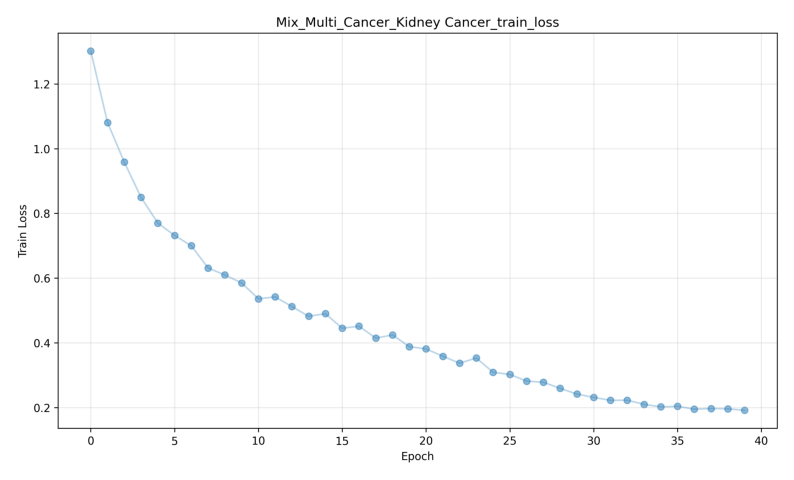

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

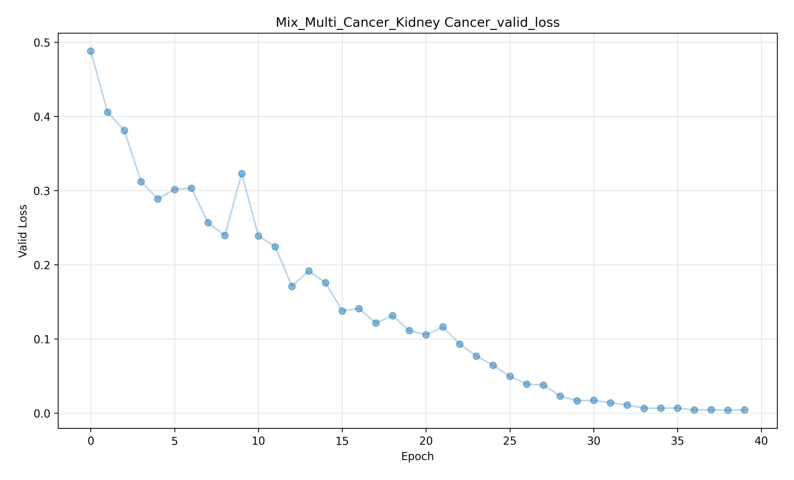

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

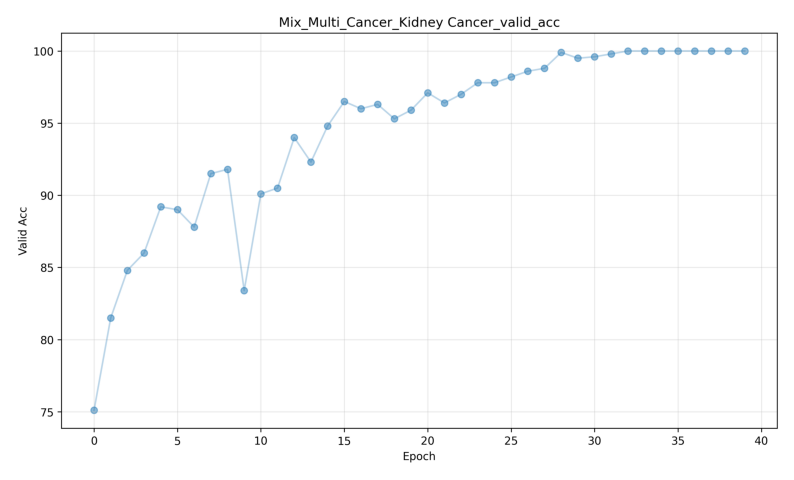

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

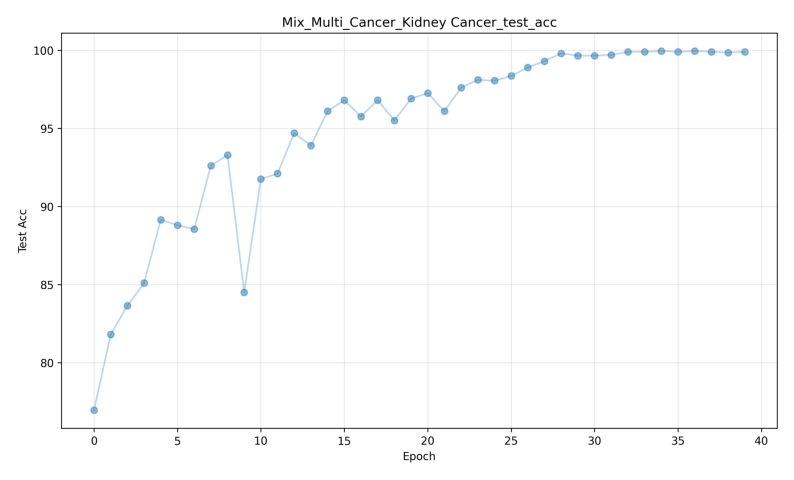

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

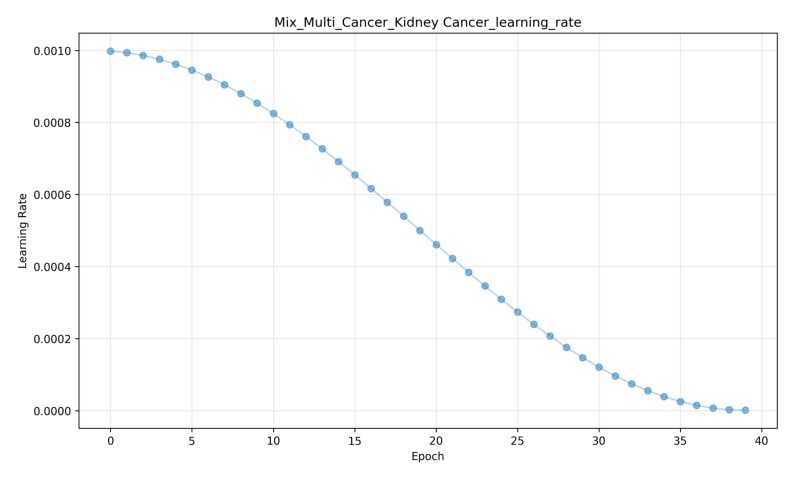

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

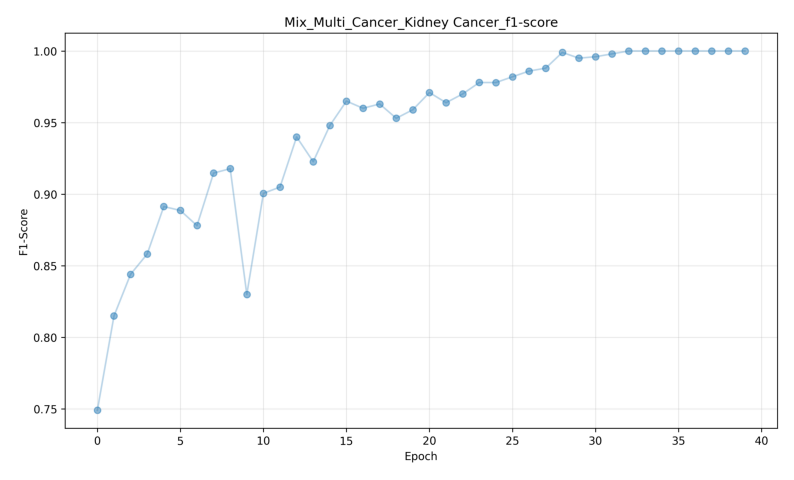

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
title = "Mix_Multi_Cancer_"
title = title + subset_name
plot_save(train_losses, valid_losses, valid_accs, test_accs, lrs, title, f1s)